# LSTM Training

In [28]:
import os
import pickle
import sys
import re

import warnings
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

sys.path.append("../src")
warnings.filterwarnings("ignore")


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train = pd.read_csv('../data/raw/data_train.zip', index_col='Unnamed: 0')
train.shape

(814262, 11)

In [3]:
test = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0')
test.shape

(202937, 11)

In [4]:
data = pd.concat([train, test], axis=0)

As we can see, we have coordinates for an entry and an exit point, where the trajectory happened. We can then calculate the distance that his trajectory took by calculating the euclidian distance between these two points. Let's do that.

In [5]:
def euclidian_distance(x_one, y_one, x_two, y_two):
    return np.sqrt(np.power((x_one-x_two), 2) + np.power((y_one-y_two), 2))

def minkowski_distance(x_one, y_one, x_two, y_two):
    return abs(x_one-x_two) + abs(y_one-y_two)

data['euclidian_distance'] = np.sqrt(np.power(data.x_entry.values-data.x_exit.values, 2)+np.power(data.y_entry.values-data.y_exit.values, 2))

data['minkowski_distance'] = np.abs(data.x_entry.values-data.x_exit.values) + np.abs(data.y_entry.values-data.y_exit.values)

Let's explore a little bit about this new variable, beginning by grouping it according wit the hash variable, that indicates one-day trajectory.

As we can see, on average the distance traveled is a little skewed towards the right tail.

We also can explore distance in the time domain, I want to investigate in which time of the day the trajectories has longest distances.

Minimum value for time_entry: 0 days 00:00:00
Maximum value for time_entry: 0 days 16:00:00
Minimum value for time_exit: 0 days 00:00:00
Maximum value for time_exit: 0 days 16:00:00


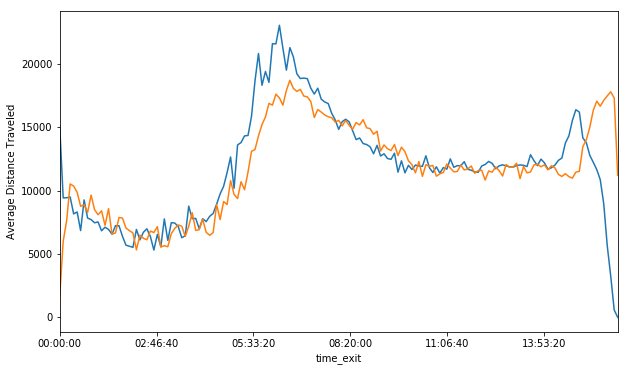

In [6]:
# transforming time variable to timedelta format in pandas

data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

print('Minimum value for time_entry: {}'.format(data.time_entry.min()))
print('Maximum value for time_entry: {}'.format(data.time_entry.max()))

print('Minimum value for time_exit: {}'.format(data.time_entry.min()))
print('Maximum value for time_exit: {}'.format(data.time_entry.max()))

entry_avg = data.set_index('time_entry').euclidian_distance.resample('0.1H').mean()
exit_avg = data.set_index('time_exit').euclidian_distance.resample('0.1H').mean()


ax = plt.subplot(2, 1, 1)
ax.set_ylabel('Average Distance Traveled')
ax.set_xlabel('Time')

entry_avg.plot(ax=ax, figsize=(10, 13))
exit_avg.plot(ax=ax, figsize=(10, 13))

The plot above shows the average distance traveled during the day for entry_time and exit_time. As expected, they are correlated and shifted because they represent the same value for exactly the same time.

An interesting point here is how we have two peaks: one approximately during 6 AM and another after lunch time, let's here the exact times.

In [7]:
exit_avg.sort_values(ascending=False).head(10)

time_exit
06:36:00    18727.014658
06:42:00    18084.512500
06:54:00    18007.645112
06:30:00    17925.626266
06:48:00    17847.258010
15:48:00    17820.698981
06:12:00    17630.953016
15:42:00    17493.566872
07:00:00    17480.962316
07:06:00    17417.260758
Name: euclidian_distance, dtype: float64

It is clear now that during the morning the distance traveled are higher than in other time during day, probably due people going to work. The same is happening for people who is starting leave, let's say **15:42-15:48**.

**INSIGHT:** We could check this online looking for statistics about atlanta's city to see if our assumptions matches. Also, in order to predict who is going to leave the city during 15:00 - 16:00 we can create a variable indicaing if the person took a trajectory from out to inside the city at time during **06:00-07:00** AM. Let's explore in the following.

To continue our investigation, let's create a variable to see if a person is inside or not the city for its entry point and its exit point.

In [8]:
def is_inside_city(x, y):
    if (3750901.5068 <= x <= 3770901.5068) and (-19268905.6133 <= y <= -19208905.6133):
        return 1
    else:
        return 0

data['is_inside_city_entry'] = [is_inside_city(x, y) for x, y in zip(data.x_entry, data.y_entry)]
data['is_inside_city_exit'] = [is_inside_city(x, y) for x, y in zip(data.x_exit, data.y_exit)]

Again, let's explore this variable temporally.

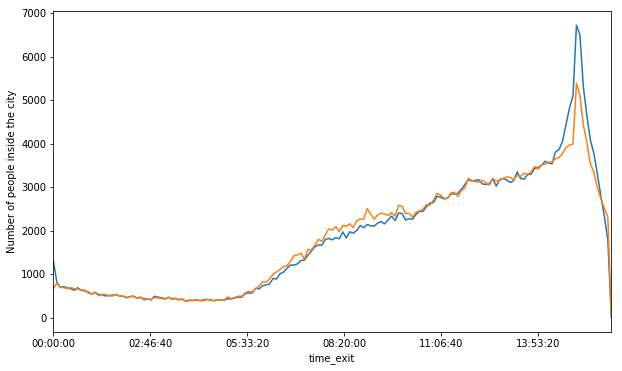

In [9]:
entry_avg_inside = data.set_index('time_entry').resample('0.1H').is_inside_city_entry.sum()
exit_avg_inside = data.set_index('time_exit').resample('0.1H').is_inside_city_exit.sum()


ax = plt.subplot(2, 1, 1)
ax.set_ylabel('Number of people inside the city')
ax.set_xlabel('Time')

entry_avg_inside.plot(ax=ax, figsize=(10, 13))
exit_avg_inside.plot(ax=ax, figsize=(10, 13))

So, as the day passes, people are getting more inside the city, let's check all the ones who left between 06:00-07:00 if the exit point was inside city.

In [10]:
exit_avg_inside.sort_values(ascending=False).head(10)

time_exit
15:00:00    5389
15:06:00    5105
15:12:00    4421
15:18:00    4027
14:54:00    3993
14:48:00    3971
14:42:00    3910
14:36:00    3768
14:30:00    3683
14:24:00    3654
Name: is_inside_city_exit, dtype: int64

In [11]:
entry_avg_inside.sort_values(ascending=False).head(10)

time_entry
15:00:00    6725
15:06:00    6499
15:12:00    5290
14:54:00    5097
14:48:00    4819
15:18:00    4644
14:42:00    4444
15:24:00    4081
14:36:00    4057
14:30:00    3867
Name: is_inside_city_entry, dtype: int64

Let's explore how the variables are distributed for people leaving and entering the city.

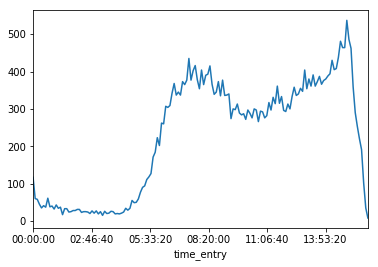

In [12]:
entering = data[(data.is_inside_city_entry==0) & (data.is_inside_city_exit==1)]

entering.set_index('time_entry').resample('0.1H').count().hash.plot()

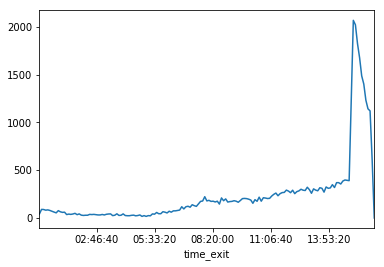

In [13]:
leaving = data[(data.is_inside_city_entry==1) & (data.is_inside_city_exit==0)]

leaving.set_index('time_exit').resample('0.1H').count().hash.plot()

In [14]:
six_am = pd.to_timedelta('06:00:00')
seven_am = pd.to_timedelta('07:00:00')

data[(data.time_entry >= six_am) & (data.time_entry <= seven_am)
     & (data.is_inside_city_entry==0) & (data.is_inside_city_exit==1)].head()

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,euclidian_distance,minkowski_distance,is_inside_city_entry,is_inside_city_exit
131,001347748b8caf13e837cff3e969c15d_15,traj_001347748b8caf13e837cff3e969c15d_15_1,06:55:04,07:17:49,NaN,NaN,NaN,3.757704e+06,-1.928421e+07,3.757788e+06,-1.923512e+07,49085.130525,49168.549139,0,1
367,0024452fea3e42f9ca0dcf6dd3ff3336_19,traj_0024452fea3e42f9ca0dcf6dd3ff3336_19_4,06:56:53,07:11:53,0.000000,0.000000,0.000000,3.771933e+06,-1.922423e+07,3.766987e+06,-1.922847e+07,6515.040815,9186.630454,0,1
414,0029d917352b7668953513cfc3b4478f_19,traj_0029d917352b7668953513cfc3b4478f_19_2,06:41:03,07:15:29,4.790038,4.790038,4.790038,3.757789e+06,-1.914088e+07,3.767774e+06,-1.923552e+07,95165.067864,104625.110864,0,1
714,004133eb5cc1834d063c72f93de9b136_1,traj_004133eb5cc1834d063c72f93de9b136_1_0,06:29:59,06:52:30,17.850000,17.850000,17.850000,3.742407e+06,-1.924645e+07,3.756150e+06,-1.924978e+07,14141.432748,17074.601572,0,1
1326,006e177f08c0d197c904d18c96305a24_31,traj_006e177f08c0d197c904d18c96305a24_31_6,06:32:02,06:51:53,NaN,NaN,NaN,3.758184e+06,-1.916095e+07,3.757353e+06,-1.924205e+07,81103.419584,81929.611289,0,1


We can also calculate the trajectory mean time using time_exit - time_entry variables.

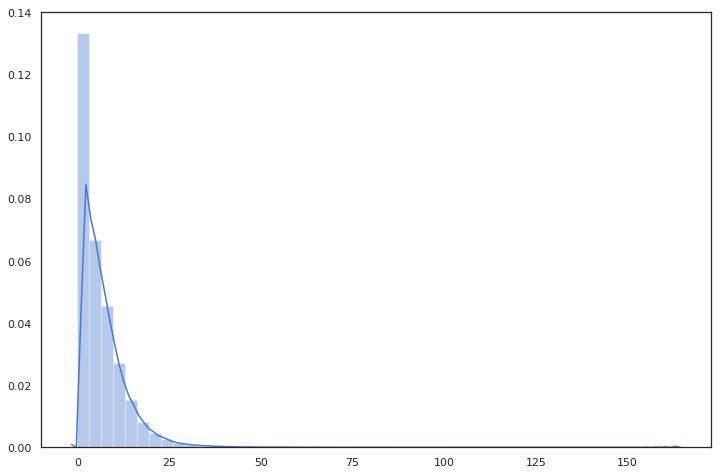

In [15]:
data['trajectory_time'] = (data.time_exit - data.time_entry) / np.timedelta64(1, 'm')

data_grouped = data.groupby('hash').trajectory_time

fig = plt.figure(figsize=(12, 8))
sns.set(style="white", palette="muted", color_codes=True)

sns.distplot(data_grouped.mean().values)

Also, we can plot the distribution of number of trajectores taken for each device has id.

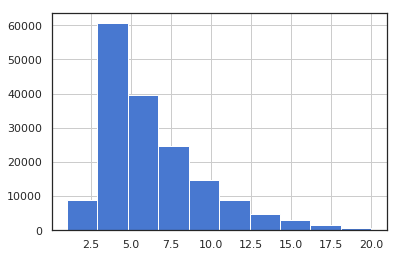

In [16]:
data.groupby('hash').trajectory_id.count().hist(bins=10)

Again, we have an approximately normal distribution.

## Feature Extraction

Let's begin by extracting some features from the data set. First, let's calculate the distance from each entry_point and exit_point to the center.

In [17]:
x_center = 3750901.5068 + ((3770901.5068-3750901.5068)/2)
y_center = -19268905.6133 + ((-19208905.6133+19268905.6133)/2)

In [18]:
data['distance_cc_entry'] = np.sqrt(((data.x_entry.values-x_center)**2) + ((data.y_entry.values-y_center)**2))
data['distance_cc_exit'] = np.sqrt(((data.x_exit.values-x_center)**2) + ((data.y_exit.values-y_center)**2))

data['diff_cc_exit_entry'] = data.distance_cc_exit - data.distance_cc_entry

We can also create another variable indicating the delta time took to get from entry pointo to exit.

In [19]:
data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

data['deltat_min'] = (data.time_exit - data.time_entry) / np.timedelta64(1, 'm')

In [20]:
data['x_diff_entry'] = data.x_entry.values-x_center
data['x_diff_exit'] = data.x_exit.values-x_center

data['y_diff_entry'] = data.y_entry.values-y_center
data['y_diff_exit'] = data.y_exit.values-y_center

In [21]:
directions_entry = []
for x, y in zip(data.x_diff_entry, data.y_diff_entry):
    directions_entry.append(math.atan2(x, y))
    
data['direction_entry'] = directions_entry

In [22]:
directions_exit = []
for x, y in zip(data.x_diff_exit, data.y_diff_exit):
    directions_exit.append(math.atan2(x, y))
    
data['direction_exit'] = directions_exit

In [23]:
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,distance_cc_entry,distance_cc_exit,diff_cc_exit_entry,deltat_min,x_diff_entry,x_diff_exit,y_diff_entry,y_diff_exit,direction_entry,direction_exit
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,145261.881023,103109.487931,-42152.393092,4.016667,-9887.737394,-10575.691847,144924.969304,102565.692331,-0.068121,-0.102748
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,85266.551966,82313.619352,-2952.932615,5.133333,-16964.317424,-15926.819770,-83561.934028,-80758.085309,-2.941300,-2.946875
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,56962.437581,56283.231185,-679.206396,9.883333,-16033.686481,-16086.006642,-54659.310214,-53935.540259,-2.856258,-2.851747
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,55736.470981,54033.065612,-1703.405368,19.550000,-16021.441337,-16092.685811,-53384.151345,-51580.981406,-2.850029,-2.839174


In [24]:
data['diff_cc_exit_entry_direction'] = data.diff_cc_exit_entry.values * data.direction_entry.values
data['diff_cc_exit_exit_direction'] = data.diff_cc_exit_entry.values * data.direction_exit.values

### Aggregating features

We can also work with aggregating features. In this way we can measure features representing if a person has taken a lot of paths, velocity, average, sum, distance, etc.

In [25]:
cols_to_agg = ['euclidian_distance', 'minkowski_distance', 'deltat_min', 'distance_cc_entry', 'distance_cc_exit', 'diff_cc_exit_entry', 
               'direction_entry', 'direction_exit', 'is_inside_city_exit', 'diff_cc_exit_entry_direction', 
              'diff_cc_exit_exit_direction']
window = 5

agg_features = (data.groupby(['hash', 'time_entry', 'trajectory_id'])[cols_to_agg]
                .mean()
                .shift(1)
                .rolling(window, min_periods=1)
                .agg(['mean', 'max', 'std', 'min', 'sum']))

agg_features.columns = ["_".join(x) for x in agg_features.columns.ravel()]
data = data.merge(agg_features.reset_index(), 
                    on=['hash', 'trajectory_id', 'time_entry'])
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,diff_cc_exit_entry_direction_mean,diff_cc_exit_entry_direction_max,diff_cc_exit_entry_direction_std,diff_cc_exit_entry_direction_min,diff_cc_exit_entry_direction_sum,diff_cc_exit_exit_direction_mean,diff_cc_exit_exit_direction_max,diff_cc_exit_exit_direction_std,diff_cc_exit_exit_direction_min,diff_cc_exit_exit_direction_sum
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,2871.464400,2871.464400,NaN,2871.464400,2871.464400,4331.086115,4331.086115,NaN,4331.086115,4331.086115
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,5778.462317,8685.460233,4111.115880,2871.464400,11556.924633,6516.504778,8701.923441,3090.648713,4331.086115,13033.009557
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,4498.971195,8685.460233,3655.397308,1939.988952,13496.913585,4989.978052,8701.923441,3430.292446,1936.924601,14969.934157


We can also calculate the number of trajectories taken by an id. 

In [29]:
data['trajectory_number'] = data.trajectory_id.apply(lambda x: int(re.findall('_\d+$', x)[0].strip('_')))

count_trajectories = (data.groupby(['hash','time_entry', 'trajectory_id'])
                      .trajectory_number.mean()
                      .shift(1)
                      .rolling(5, min_periods=1)
                      .agg(['sum']))
count_trajectories.columns = ["count_"+x for x in count_trajectories.columns.ravel()]
data = data.merge(count_trajectories.reset_index(), 
                    on=['hash', 'trajectory_id', 'time_entry'])
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,diff_cc_exit_entry_direction_std,diff_cc_exit_entry_direction_min,diff_cc_exit_entry_direction_sum,diff_cc_exit_exit_direction_mean,diff_cc_exit_exit_direction_max,diff_cc_exit_exit_direction_std,diff_cc_exit_exit_direction_min,diff_cc_exit_exit_direction_sum,trajectory_number,count_sum
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,NaN,2871.464400,2871.464400,4331.086115,4331.086115,NaN,4331.086115,4331.086115,1,0.0
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,4111.115880,2871.464400,11556.924633,6516.504778,8701.923441,3090.648713,4331.086115,13033.009557,2,1.0
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,3655.397308,1939.988952,13496.913585,4989.978052,8701.923441,3430.292446,1936.924601,14969.934157,3,3.0


In [30]:
last_features = (data.groupby(['hash', 'time_entry', 'trajectory_id'])[cols_to_agg+['y_entry', 'x_entry']]
                .mean()
                .shift(1))

last_features.columns = ['last_'+x for x in last_features.columns.ravel()]
data = data.merge(last_features.reset_index(), 
                    on=['hash', 'trajectory_id', 'time_entry'])

## Training

In [31]:
three_oclock = pd.to_timedelta('15:00:00')
four_oclock = pd.to_timedelta('16:00:00')

train = data.loc[:814262]
test = data.loc[814262:]

data_train = data[(data.time_exit >= three_oclock) & (train.time_exit <= four_oclock)].copy()

In [32]:
data_train.shape

(134063, 98)

In [33]:
data_train.columns

Index(['hash', 'trajectory_id', 'time_entry', 'time_exit', 'vmax', 'vmin',
       'vmean', 'x_entry', 'y_entry', 'x_exit', 'y_exit', 'euclidian_distance',
       'minkowski_distance', 'is_inside_city_entry', 'is_inside_city_exit',
       'trajectory_time', 'distance_cc_entry', 'distance_cc_exit',
       'diff_cc_exit_entry', 'deltat_min', 'x_diff_entry', 'x_diff_exit',
       'y_diff_entry', 'y_diff_exit', 'direction_entry', 'direction_exit',
       'diff_cc_exit_entry_direction', 'diff_cc_exit_exit_direction',
       'euclidian_distance_mean', 'euclidian_distance_max',
       'euclidian_distance_std', 'euclidian_distance_min',
       'euclidian_distance_sum', 'minkowski_distance_mean',
       'minkowski_distance_max', 'minkowski_distance_std',
       'minkowski_distance_min', 'minkowski_distance_sum', 'deltat_min_mean',
       'deltat_min_max', 'deltat_min_std', 'deltat_min_min', 'deltat_min_sum',
       'distance_cc_entry_mean', 'distance_cc_entry_max',
       'distance_cc_entry_std'

In [34]:
data_train = data_train.fillna(value=0)

features = ['vmax', 'vmin',
       'vmean', 'x_entry', 'y_entry',
       'is_inside_city_entry', 'trajectory_time',
       'distance_cc_entry',
       'x_diff_entry', 'direction_entry',
       'deltat_min_mean', 'deltat_min_max', 'deltat_min_std', 'deltat_min_min',
       'deltat_min_sum', 'distance_cc_entry_mean', 'distance_cc_entry_max',
       'distance_cc_entry_std', 'distance_cc_entry_min',
       'distance_cc_entry_sum', 'distance_cc_exit_mean', 
        'euclidian_distance_mean', 'euclidian_distance_max',
       'euclidian_distance_std', 'euclidian_distance_min',
       'euclidian_distance_sum', 'minkowski_distance_mean',
       'minkowski_distance_max', 'minkowski_distance_std',
       'minkowski_distance_min', 'minkowski_distance_sum',
       'distance_cc_exit_max', 'distance_cc_exit_std', 'distance_cc_exit_min',
       'distance_cc_exit_sum', 'diff_cc_exit_entry_mean',
       'diff_cc_exit_entry_max', 'diff_cc_exit_entry_std',
       'diff_cc_exit_entry_min', 'diff_cc_exit_entry_sum',
       'direction_entry_mean', 'direction_entry_max', 'direction_entry_std',
       'direction_entry_min', 'direction_entry_sum', 'direction_exit_mean',
       'direction_exit_max', 'direction_exit_std', 'direction_exit_min',
       'direction_exit_sum', 'trajectory_number', 'count_sum', 'last_euclidian_distance',
       'last_deltat_min', 'last_distance_cc_entry', 'last_distance_cc_exit', 'last_minkowski_distance',
       'last_diff_cc_exit_entry', 'last_direction_entry',
       'last_direction_exit', 'last_y_entry', 'last_is_inside_city_exit', 'is_inside_city_exit_mean',
       'is_inside_city_exit_max', 'is_inside_city_exit_std',
       'is_inside_city_exit_min', 'is_inside_city_exit_sum', 'diff_cc_exit_entry_direction_mean', 'diff_cc_exit_entry_direction_max',
       'diff_cc_exit_entry_direction_std', 'diff_cc_exit_entry_direction_min',
       'diff_cc_exit_entry_direction_sum', 'diff_cc_exit_exit_direction_mean',
       'diff_cc_exit_exit_direction_max', 'diff_cc_exit_exit_direction_std',
       'diff_cc_exit_exit_direction_min', 'diff_cc_exit_exit_direction_sum', 'y_diff_entry']

target = ['is_inside_city_exit']

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

dt_train, dt_test = train_test_split(data_train, test_size=0.20, random_state=20)

In [36]:
hashs_train = dt_train.hash.unique().tolist()
hashs_test  = dt_test.hash.unique().tolist()

In [37]:
train_train = train[train.hash.isin(hashs_train)]
train_test = train[train.hash.isin(hashs_test)]

In [38]:
minmax = MinMaxScaler()

minmax.fit(train_train[features])

train_train[features] = minmax.transform(train_train[features])
train_test[features] = minmax.transform(train_test[features])
train_train.shape, train_test.shape

((651877, 98), (162385, 98))

In [36]:
#data.head(100).groupby(['hash', 'trajectory_number'])[features].mean().unstack()

In [37]:
train_train = train_train.fillna(0)
train_test = train_test.fillna(0)

def process_sequences(data, target):
    hashs = set(data.hash.values)
    seqs = []
    labels = []
    
    for hash_ in tqdm(hashs):
        seqs.append(data.query('hash == @hash_')[features].iloc[-5:, :].values)
        labels.append(data.query('hash == @hash_')[target].iloc[-5:, :].values)
        
    return seqs, labels

sequences_train, labels_train = process_sequences(train_train, target=target)
sequences_test, labels_test = process_sequences(train_test, target=target)

In [37]:
import pickle
import os

PATH = 'D:\Documents_\ey-geolock'
with open(os.path.join(PATH, 'sequences_train.pkl'), 'wb') as fp:
    pickle.dump(sequences_train, fp)

with open(os.path.join(PATH,'labels_train.pkl'), 'wb') as fp:
    pickle.dump(labels_train, fp)

with open(os.path.join(PATH,'sequences_test.pkl'), 'wb') as fp:
    pickle.dump(sequences_test, fp)

with open(os.path.join(PATH,'labels_test.pkl'), 'wb') as fp:
    pickle.dump(labels_test, fp)

In [39]:
PATH = '../data/preprocessed/'

with open(os.path.join(PATH, 'sequences_train.pkl'), 'rb') as fp:
     sequences_train = pickle.load(fp)

with open(os.path.join(PATH,'labels_train.pkl'), 'rb') as fp:
    labels_train = pickle.load(fp)

with open(os.path.join(PATH,'sequences_test.pkl'), 'rb') as fp:
    sequences_test = pickle.load(fp)

with open(os.path.join(PATH,'labels_test.pkl'), 'rb') as fp:
    labels_test = pickle.load(fp)

In [40]:
def pad_features(sequences, seq_length, seq_features):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    padding = np.zeros(seq_features)
    # getting the correct rows x cols shape
    features = np.zeros((len(sequences), seq_length, seq_features), dtype=float)

    # for each review, I grab that review and 
    for i, row in enumerate(sequences):
        features[i, -len(row):, :] = np.array(row)[:seq_length]
    
    return features

seq_length = 5
seq_features = len(features)

train_matrix = pad_features(sequences_train, seq_length, seq_features)
test_matrix = pad_features(sequences_test, seq_length, seq_features)

In [41]:
train_matrix.shape, test_matrix.shape

((107250, 5, 78), (26813, 5, 78))

In [42]:
targets_train = np.array([list(label[len(label)-1])[0] for label in labels_train])
targets_test = np.array([list(label[len(label)-1])[0] for label in labels_test])

In [43]:
split_frac = 0.90

split_idx = int(len(targets_train)*split_frac)
train_x, val_x = train_matrix[:split_idx], train_matrix[split_idx:]
train_y, val_y = targets_train[:split_idx], targets_train[split_idx:]

print('\t\t\tFeature Shapes:')
print('Train set: \t\t{}'.format(train_x.shape))
print('\nValidation set: \t{}'.format(val_x.shape))
print('\nTest set: \t\t{}'.format(test_matrix.shape))

			Feature Shapes:
Train set: 		(96525, 5, 78)

Validation set: 	(10725, 5, 78)

Test set: 		(26813, 5, 78)


In [44]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data  = TensorDataset(torch.from_numpy(test_matrix), torch.from_numpy(targets_test))

batch_size = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader  = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [45]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([64, 5, 78])
Sample input: 
 tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.8236,  0.4979,  0.0947],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.8236,  0.5132,  0.5405],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.8236,  0.5132,  0.5511],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.8236,  0.5132,  0.5530],
         [ 0.0061,  0.0061,  0.0061,  ...,  0.8236,  0.5132,  0.7779]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.8052,  0.5139,  0.2662],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.8052,  0.4925,  0.2653],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.8236,  0.4979,  0.2652]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.8218,  0.5062,  0.3925],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.8199,  0.5057,  0.4862],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.8199,  0.5057,  0.4983],
         [ 0.

In [46]:
from lstm import LSTM
import torch.nn as nn

# Instantiate the model w/ hyperparams
output_size = 1
embedding_dim = seq_features
hidden_dim = 64
n_layers = 3

net = LSTM(output_size, embedding_dim, hidden_dim, n_layers)

print(net)

LSTM(
  (lstm): LSTM(78, 64, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [47]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)#, momentum = 0.9)

In [ ]:
from sklearn.metrics import f1_score

net.train_nn(train_loader, valid_loader, scorer=f1_score, batch_size=batch_size, criterion=criterion, 
             optimizer=optimizer, n_epochs=10, clip=5, print_every=25, train_on_gpu=False)

In [79]:



valid_labels = []
pred_labels = []
# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    net.train()
    for inputs, labels in train_loader:
        if len(inputs)!=batch_size:
            break
            
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs.float(), h)
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        # Get validation loss
    val_h = net.init_hidden(batch_size)
    val_losses = []
    num_correct = 0
    net.eval()
    for inputs, labels in valid_loader:
        if len(inputs)!=batch_size:
            break

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        val_h = tuple([each.data for each in val_h])

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        output, val_h = net(inputs.float(), val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())
                
        # convert output probabilities to predicted class (0 or 1)
        pred = torch.round(output.squeeze())  # rounds to the nearest integer
        
        valid_labels.append(labels)
        pred_labels.append(pred)

        # compare predictions to true label
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        num_correct += np.sum(correct)

    predicted = np.array([label for tensor in pred_labels for label in tensor.cpu().detach().numpy()])
    true     = np.array([label for tensor in valid_labels for label in tensor.cpu().detach().numpy()])
    
    print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
    test_f1score = f1_score(true, predicted)
    print("Test accuracy: {:.3f}".format(test_f1score))

Epoch: 1/50... Step: 965... Loss: 0.265710... Val Loss: 0.151112
Test accuracy: 0.888
Epoch: 2/50... Step: 1930... Loss: 0.300990... Val Loss: 0.156374
Test accuracy: 0.886


KeyboardInterrupt: 

In [80]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0
preds = []
trues = []
# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
with torch.no_grad():
    for inputs, labels in test_loader:
        if len(inputs)!=batch_size:
            break
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # get predicted outputs
        output, h = net(inputs.float(), h)

        # calculate loss
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())

        # convert output probabilities to predicted class (0 or 1)
        pred = torch.round(output.squeeze())  # rounds to the nearest integer
        preds.append(pred)
        trues.append(labels)
        # compare predictions to true label
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        num_correct += np.sum(correct)


    # -- stats! -- ##
    # avg test loss
    print("Test loss: {:.3f}".format(np.mean(test_losses)))

    # accuracy over all test data
    test_acc = num_correct/len(test_loader.dataset)
    print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.158
Test accuracy: 0.936


In [81]:
predicted = np.array([label for tensor in preds for label in tensor.cpu().numpy()])
true     = np.array([label for tensor in trues for label in tensor.cpu().numpy()])

In [82]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, r2_score


f1_score(true, predicted)

0.88147940599607733

## Submission

In [95]:
test[features] = minmax.transform(test[features])

In [97]:
test = test.fillna(0)

def process_sequences(data, target):
    hashs = set(data.hash.values)
    seqs = []
    labels = []
    
    for hash_ in tqdm(hashs):
        seqs.append(data.query('hash == @hash_')[features].iloc[-5:, :].values)
        labels.append(data.query('hash == @hash_')[target].iloc[-5:, :].values)
        
    return seqs, labels

sequences, labels = process_sequences(test, target=target)

100%|██████████| 33515/33515 [12:59<00:00, 42.98it/s]


In [98]:
test_matrix_final = pad_features(sequences, seq_length, seq_features)

In [99]:
targets_matrix_final = np.array([list(label[len(label)-1])[0] for label in labels])

In [100]:
test_matrix_final.shape

(33515, 5, 78)

In [120]:
dtest  = TensorDataset(torch.from_numpy(test_matrix_final), torch.from_numpy(targets_matrix_final))

batch_size = 5

dtest_loader = DataLoader(dtest, shuffle=False, batch_size=batch_size)

In [121]:
official = []
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
with torch.no_grad():
    for inputs, labels in dtest_loader:
        #if len(inputs)!=batch_size:
        #    break
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # get predicted outputs
        output, h = net(inputs.float(), h)

        # calculate loss
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())

        # convert output probabilities to predicted class (0 or 1)
        pred = torch.round(output.squeeze())  # rounds to the nearest integer
        official.append(pred)

        # compare predictions to true label
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        num_correct += np.sum(correct)


    # -- stats! -- ##
    # avg test loss
    print("Test loss: {:.3f}".format(np.mean(test_losses)))

    # accuracy over all test data
    test_acc = num_correct/len(test_loader.dataset)
    print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 3.430
Test accuracy: 2.806


In [122]:
yhat = [label for tensor in official for label in tensor.cpu().numpy()]

In [123]:
pd.Series(yhat).value_counts()

0.0    25086
1.0     8429
dtype: int64

In [117]:
test = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0')
data_test = test[test.x_exit.isnull()]

In [124]:
submission = pd.DataFrame(list(zip(data_test.trajectory_id, yhat)), columns=['id', 'target'])

In [ ]:
data_test = test[test.x_exit.isnull()]

In [125]:
submission.to_csv('../data/submission20_lstm.csv', index=False)

In [153]:
list(zip(data_train[features].columns, pipeline.steps[0][1].feature_importances_))

[('vmax', 15),
 ('vmin', 13),
 ('vmean', 25),
 ('x_entry', 158),
 ('y_entry', 74),
 ('is_inside_city_entry', 80),
 ('trajectory_time', 449),
 ('distance_cc_entry', 267),
 ('x_diff_entry', 167),
 ('direction_entry', 123),
 ('deltat_min_mean', 18),
 ('deltat_min_max', 19),
 ('deltat_min_std', 34),
 ('deltat_min_min', 6),
 ('deltat_min_sum', 15),
 ('distance_cc_entry_mean', 33),
 ('distance_cc_entry_max', 20),
 ('distance_cc_entry_std', 37),
 ('distance_cc_entry_min', 38),
 ('distance_cc_entry_sum', 0),
 ('distance_cc_exit_mean', 22),
 ('euclidian_distance_mean', 9),
 ('euclidian_distance_max', 11),
 ('euclidian_distance_std', 12),
 ('euclidian_distance_min', 12),
 ('euclidian_distance_sum', 4),
 ('minkowski_distance_mean', 9),
 ('minkowski_distance_max', 16),
 ('minkowski_distance_std', 15),
 ('minkowski_distance_min', 4),
 ('minkowski_distance_sum', 7),
 ('distance_cc_exit_max', 33),
 ('distance_cc_exit_std', 27),
 ('distance_cc_exit_min', 35),
 ('distance_cc_exit_sum', 13),
 ('diff_cc_

## Predicting x and y exit

In [50]:
clf = LGBMRegressor()

clf.fit(dt_train[features], dt_train['x_exit'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [51]:
clf.score(dt_test[features], dt_test['x_exit'])

0.8732472291607986

In [52]:
predicted_x = clf.predict(dt_test[features])

In [53]:
clf.fit(train_r[features], train_r['y_exit'])
print(clf.score(dt_test[features], dt_test['y_exit']))
predicted_y = clf.predict(dt_test[features])

0.8393761786914096


In [54]:
predict_xy = [is_inside_city(x, y) for x, y in zip(predicted_x, predicted_y)]
f1_score(dt_test[target], predict_xy)

0.8524532422246487